In [38]:
#Separate notebook to work on Topic Modelling with LDA
%pylab inline
from sys import platform
import pandas as pd

if platform == "win32":
    path = 'C:/Users/olive/'
elif platform == "darwin":
    path = '~/'

Populating the interactive namespace from numpy and matplotlib


/Users/ollyjc/Documents/GitHub/COVID-19-Sentiment-and-Compliance-Analyzer/.venv/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['beta', 'grid']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [39]:
c_df = pd.read_pickle(path + 'OneDrive - Cardiff University/Individual Project/processed data/comments.csv')
s_df = pd.read_pickle(path + 'OneDrive - Cardiff University/Individual Project/processed data/submissions.csv')

s_df = s_df.sort_values(by='datetime')
c_df = c_df.sort_values(by='datetime')

In [40]:
comments = c_df.reset_index().drop(columns=['id', 'datetime', 'sentiment', 'compound_score', 'submission_id', 'parent_id'], axis=1)

comments = comments.sample(100)

comments.head()

,body
140048,"Hancock’s incompetent deprived the NHS of PPE,..."
457047,"350, 400 at a push. 500 would be a huge leap."
471125,The creator of Vice is a shitstain too
110367,Exactly. Many (80%+) have an asymptomatic or m...
299838,"Yes, without restrictions, let the virus run i..."


In [41]:
# Remove punctuation
import re

comments['processed_text'] = comments['body'].map(lambda x: re.sub('[,\.!?]', '', x))

comments['processed_text'] = comments['processed_text'].map(lambda x: x.lower())

comments['processed_text'].head()

140048    hancock’s incompetent deprived the nhs of ppe ...
457047           350 400 at a push 500 would be a huge leap
471125               the creator of vice is a shitstain too
110367    exactly many (80%+) have an asymptomatic or mi...
299838    yes without restrictions let the virus run it'...
Name: processed_text, dtype: object

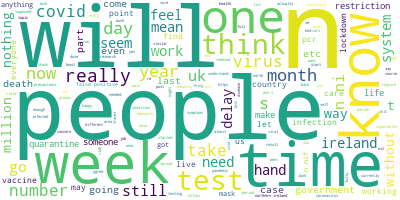

In [42]:
# EXPLORATORY ANALYSIS

from wordcloud import WordCloud

long_string = ','.join(list(comments['processed_text'].values))

wordcloud = WordCloud(background_color="white",
                      max_words=5000,
                      contour_width=3,
                      contour_color='steelblue'
                     )

wordcloud.generate(long_string)

wordcloud.to_image()

In [43]:
# Tokenize words and more text clean-up

import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),
                                            deacc=True))
data = comments.processed_text.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['hancock', 'incompetent', 'deprived', 'the', 'nhs', 'of', 'ppe', 'not', 'you']


In [25]:
#Bigram and Trigram Phrase Modelling

bigram = gensim.models.Phrases(data_words, 
                               min_count=5, 
                               threshold=100
                              )
trigram = gensim.models.Phrases(bigram[data_words], 
                                threshold=100
                               )

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [44]:
#Remove Stopwords, Make Bigrams and Lemmantize

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from',
                   'subject', 
                   're', 
                   'edu', 
                   'use'])

In [45]:
#Define functions for stopwords, bigrams, trigrams and lemmatization

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [46]:
import spacy

data_words_nostops = remove_stopwords(data_words)

data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load("en_core_web_sm", disable=['parser',
                                            'ner'])

data_lemmatized = lemmatization(data_words_bigrams)

print(data_lemmatized[:1])

[['hancock', 'incompetent', 'deprive', 'nhs', 'ppe']]


In [47]:
#Data Tranformation: Corpus and Dictionary

import gensim.corpora as corpora

id2word = corpora.Dictionary(data_words)
# id2word = corpora.Dictionary(data_lemmatized)
texts = data_words
# texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10) 

# Old LDA model
# lda_model = gensim.models.LdaMulticore(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=10) 
#                                        random_state=100,
#                                        chunksize=100,
#                                        passes=10,
#                                        per_word_topics=True)

print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]


In [48]:
from pprint import pprint

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.049*"the" + 0.025*"of" + 0.021*"to" + 0.020*"in" + 0.014*"you" + '
  '0.011*"that" + 0.008*"is" + 0.008*"be" + 0.008*"it" + 0.008*"and"'),
 (1,
  '0.030*"the" + 0.029*"to" + 0.021*"and" + 0.020*"you" + 0.016*"it" + '
  '0.013*"of" + 0.013*"in" + 0.013*"that" + 0.011*"be" + 0.010*"but"'),
 (2,
  '0.029*"the" + 0.020*"of" + 0.016*"to" + 0.014*"you" + 0.013*"ireland" + '
  '0.010*"on" + 0.010*"if" + 0.010*"it" + 0.010*"be" + 0.008*"is"'),
 (3,
  '0.028*"the" + 0.022*"to" + 0.019*"of" + 0.018*"it" + 0.017*"that" + '
  '0.016*"you" + 0.014*"and" + 0.014*"for" + 0.013*"be" + 0.011*"this"'),
 (4,
  '0.020*"the" + 0.014*"at" + 0.013*"to" + 0.013*"it" + 0.012*"and" + '
  '0.011*"you" + 0.011*"would" + 0.010*"will" + 0.010*"of" + 0.010*"be"'),
 (5,
  '0.011*"at" + 0.010*"in" + 0.008*"the" + 0.007*"of" + 0.006*"really" + '
  '0.006*"th" + 0.006*"do" + 0.006*"start" + 0.006*"sept" + 0.006*"delay"'),
 (6,
  '0.039*"the" + 0.023*"to" + 0.023*"and" + 0.021*"in" + 0.019*"of" + '
  '0.013*"it

In [31]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.38819664403441295


In [32]:
# Hyperparameter Tuning
def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                         texts=data_lemmatized, 
                                         dictionary=id2word,
                                         coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [49]:
import pyLDAvis.gensim
import pickle
import pyLDAvis

pyLDAvis.enable_notebook()

LDAvis_data_path = os.path.join('./results/ldavis_prepared_'+str(num_topics))

if True:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model,
                                              corpus,
                                              id2word
                                             )
    with open(LDAvis_data_path, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
    with open(LDAvis_data_path, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
        
    pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_' + str(num_topics) + '.html')
    
    LDAvis_prepared

ModuleNotFoundError: No module named 'pyLDAvis'

In [33]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

#Can take a while to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], 
                                                  dictionary=id2word, 
                                                  k=k, 
                                                  a=a,
                                                  b=b)
                    print('Alert')
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
                    
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv',
                                       index=False)
    pbar.close()


  0%|          | 0/540 [00:00<?, ?it/s]

ValueError: Stop argument for islice() must be None or an integer: 0 <= x <= sys.maxsize.